In [1]:
import torch
import torchvision.models as models
import torch.nn as nn
import matplotlib.pyplot as plt
torch.manual_seed(0)

In [2]:
from Data_Loader import *
from Generator import *
from Discriminator import *

In [3]:
import torch.nn.functional as F

adv_criterion = nn.MSELoss()
recon_criterion = nn.L1Loss()

n_epochs = 10
dim_A = 3
dim_B = 3
display_step = 200
batch_size = 1
lr = 0.0002
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
import os
import shutil

def remove_files_in_directory(directory_path):
    if os.path.exists(directory_path):
        for filename in os.listdir(directory_path):
            file_path = os.path.join(directory_path, filename)
            try:
                if os.path.isfile(file_path):
                    os.unlink(file_path)
            except Exception as e:
                print(f"Failed to delete {file_path}: {e}")
    else:
        print(f"The directory '{directory_path}' does not exist.")

In [6]:
class CycleGan:
  def __init__(self, dim_A, dim_B,emotion,load_model=False):
    self.gen_AB = Generator(dim_A, dim_B).to(device)
    self.gen_BA = Generator(dim_B, dim_A).to(device)
    self.gen_opt = torch.optim.Adam(list(self.gen_AB.parameters()) + list(self.gen_BA.parameters()), lr=lr, betas=(0.5, 0.999))
    self.disc_A = Discriminator(dim_A).to(device)
    self.disc_A_opt = torch.optim.Adam(self.disc_A.parameters(), lr=lr, betas=(0.5, 0.999))
    self.disc_B = Discriminator(dim_B).to(device)
    self.disc_B_opt = torch.optim.Adam(self.disc_B.parameters(), lr=lr, betas=(0.5, 0.999))
    self.emotion = emotion
    if load_model:
      self.load_model('Gan_Results/Models')

  def weights_init(self, m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)

  def load_model(self, path):
    path = f'{path}/{self.emotion}'
    model = os.listdir(path)[0]
    pre_dict = torch.load(f'{path}/{model}')

    self.gen_AB.load_state_dict(pre_dict['gen_AB'])
    self.gen_BA.load_state_dict(pre_dict['gen_BA'])
    self.gen_opt.load_state_dict(pre_dict['gen_opt'])
    self.disc_A.load_state_dict(pre_dict['disc_A'])
    self.disc_A_opt.load_state_dict(pre_dict['disc_A_opt'])
    self.disc_B.load_state_dict(pre_dict['disc_B'])
    self.disc_B_opt.load_state_dict(pre_dict['disc_B_opt'])

  def weight_initialization(self):
    self.gen_AB = self.gen_AB.apply(self.weights_init)
    self.gen_BA = self.gen_BA.apply(self.weights_init)
    self.disc_A = self.disc_A.apply(self.weights_init)
    self.disc_B = self.disc_B.apply(self.weights_init)

  def save_model(self,path,cur_step):
    em = self.emotion
    remove_files_in_directory(f'{path}/{em}/')
    torch.save({
                        'gen_AB': self.gen_AB.state_dict(),
                        'gen_BA': self.gen_BA.state_dict(),
                        'gen_opt': self.gen_opt.state_dict(),
                        'disc_A': self.disc_A.state_dict(),
                        'disc_A_opt': self.disc_A_opt.state_dict(),
                        'disc_B': self.disc_B.state_dict(),
                        'disc_B_opt': self.disc_B_opt.state_dict()
      }, f"{path}/{em}/Step_{cur_step}.pth")

  def set_dataset(self,dataset):
    self.target_dataset = FilteredDataset(dataset,self.emotion)

In [7]:
def get_identity_loss(real_X, gen_YX, identity_criterion):

    identity_X = gen_YX(real_X)
    identity_loss = identity_criterion(real_X, identity_X)
    return identity_loss, identity_X

In [8]:
def get_cycle_consistency_loss(real_X, fake_Y, gen_YX, cycle_criterion):

    cycle_X = gen_YX(fake_Y)
    cycle_loss = cycle_criterion(real_X, cycle_X)

    return cycle_loss, cycle_X

In [9]:
def Loss_plot(gen, disc ,class_target):

  gen.pop(0)
  x = [i * display_step for i in  range(len(gen))]
  plt.subplot(1, 2, 1)
  plt.plot(x, gen, label='Generator Loss', color='blue')
  plt.xlabel('Iterations')
  plt.ylabel('Loss')
  plt.title('Generator Loss')
  plt.legend()

  disc.pop(0)
  plt.subplot(1, 2, 2)
  plt.plot(x, disc, label='Discriminator Loss', color='red')
  plt.xlabel('Iterations')
  plt.ylabel('Loss')
  plt.title('Discriminator Loss')
  plt.legend()

  plt.tight_layout()
  plt.show()

In [10]:
import numpy as np
plt.rcParams["figure.figsize"] = (6, 6)


def train(Emotion_gan,save_model=True):
    Fid_scores = []
    loss_gen = []
    loss_disc = []
    mean_generator_loss = 0
    mean_discriminator_loss = 0
    Emotion_gan.set_dataset(dataset)
    print(Emotion_gan.target_dataset[0][1])
    source_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    target_loader = DataLoader(Emotion_gan.target_dataset, batch_size=batch_size, shuffle=True)

    cur_step = 0

    for epoch in range(n_epochs):
        fake_features_list = []
        real_features_list = []

        for real_A, real_B in zip(source_loader,target_loader):
            #print(real_A[0].shape, real_B[0].shape)
            #Real B --> Fake B:Target
            real_A = real_A[0]
            real_B = real_B[0]

            real_A = nn.functional.interpolate(real_A, size=target_shape)
            real_B = nn.functional.interpolate(real_B, size=target_shape)
            cur_batch_size = len(real_A)
            real_A = real_A.to(device)
            real_B = real_B.to(device)

            Emotion_gan.disc_A_opt.zero_grad()
            with torch.no_grad():
                fake_A = Emotion_gan.gen_BA(real_B)
            disc_A_loss = get_disc_loss(real_A, fake_A, Emotion_gan.disc_A, adv_criterion)
            disc_A_loss.backward(retain_graph=True)
            Emotion_gan.disc_A_opt.step()

            Emotion_gan.disc_B_opt.zero_grad()
            with torch.no_grad():
                fake_B = Emotion_gan.gen_AB(real_A)
            disc_B_loss = get_disc_loss(real_B, fake_B, Emotion_gan.disc_B, adv_criterion)
            disc_B_loss.backward(retain_graph=True)
            Emotion_gan.disc_B_opt.step()

            Emotion_gan.gen_opt.zero_grad()
            gen_loss, fake_A, fake_B = get_gen_loss(
                real_A, real_B, Emotion_gan.gen_AB, Emotion_gan.gen_BA, Emotion_gan.disc_A, Emotion_gan.disc_B, adv_criterion, recon_criterion, recon_criterion
            )
            gen_loss.backward()
            Emotion_gan.gen_opt.step()

            mean_discriminator_loss += disc_A_loss.item() / display_step
            mean_generator_loss += gen_loss.item() / display_step

            #FID
#             with torch.no_grad():
#                 Resnet_real_B = preprocess(real_B)
#                 real_features = classifier(Resnet_real_B)
#                 real_features_list.append(real_features)

#                 Resnet_fake_B = preprocess(fake_B)
#                 fake_features = classifier(Resnet_fake_B)
#                 fake_features_list.append(fake_features)

            ### Visualization code ###
            if cur_step % display_step == 0:
                loss_gen.append(mean_generator_loss)
                loss_disc.append(mean_discriminator_loss)
                print(f"Epoch {epoch}: Step {cur_step}: Generator (U-Net) loss: {mean_generator_loss}, Discriminator loss: {mean_discriminator_loss}")
                #show_tensor_images(torch.cat([real_A, real_B]), size=(dim_A, target_shape[0], target_shape[1]))
                #show_tensor_images(torch.cat([real_B, fake_B]), size=(dim_B, target_shape[0], target_shape[1]),step=cur_step,target=Emotion_gan.emotion)
                show_tensor_images(real_B, fake_B ,step=cur_step,target=Emotion_gan.emotion, num_images=batch_size)
                save_tensor_image(fake_B,cur_step,Emotion_gan.emotion)
                mean_generator_loss = 0
                mean_discriminator_loss = 0
                if save_model:
                    Emotion_gan.save_model('Gan_Results/Models',cur_step)
            cur_step += len(real_A)

#         with torch.no_grad():

#             mu_fake, mu_real, sigma_fake, sigma_real = get_stat(fake_features_list,real_features_list)
#             cur_fid = frechet_distance(mu_real, mu_fake, sigma_real, sigma_fake).item()
#             print(f'FID Score in epoch {epoch} is: {cur_fid}')
#             Fid_scores.append(cur_fid)
    return loss_gen, loss_disc

1
Epoch 0: Step 0: Generator (U-Net) loss: 0.09118344306945801, Discriminator loss: 0.002721593677997589


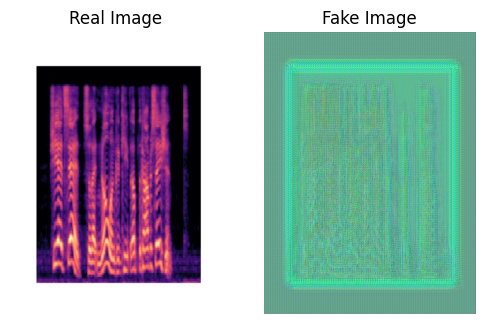

Epoch 1: Step 200: Generator (U-Net) loss: 2.466791793704032, Discriminator loss: 0.22690892048180103


<Figure size 600x600 with 0 Axes>

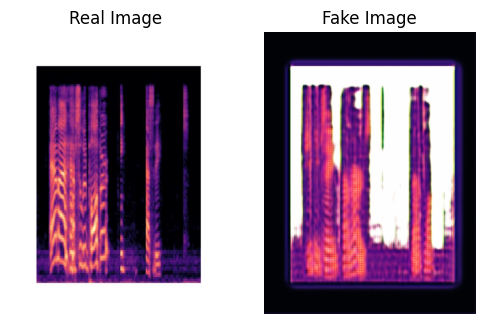

Epoch 2: Step 400: Generator (U-Net) loss: 1.5691366475820547, Discriminator loss: 0.22757845371961583


<Figure size 600x600 with 0 Axes>

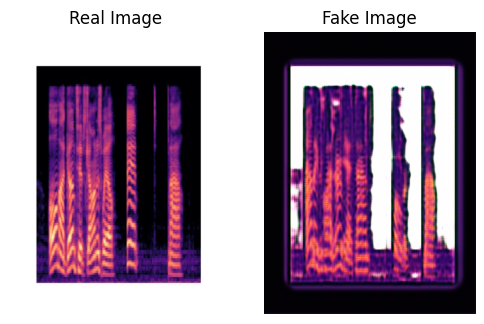

Epoch 4: Step 600: Generator (U-Net) loss: 2.3806562936306, Discriminator loss: 0.23800140343606488


<Figure size 600x600 with 0 Axes>

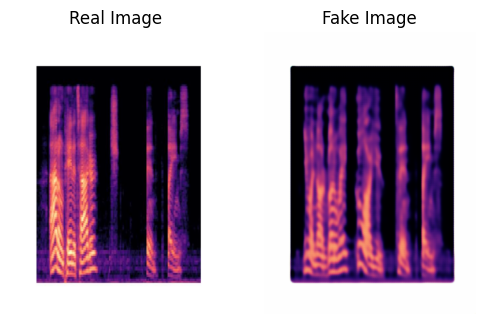

Epoch 5: Step 800: Generator (U-Net) loss: 1.3935681641101845, Discriminator loss: 0.2502430391311647


<Figure size 600x600 with 0 Axes>

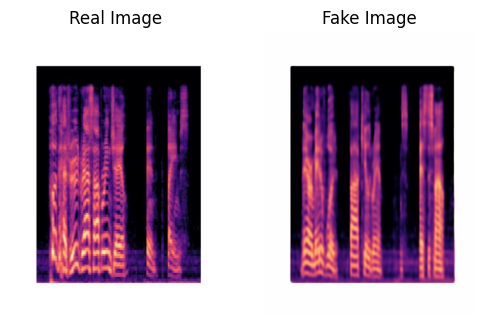

Epoch 7: Step 1000: Generator (U-Net) loss: 1.2632673299312587, Discriminator loss: 0.2505232578516008


<Figure size 600x600 with 0 Axes>

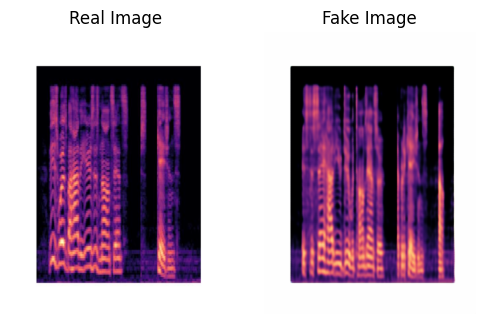

Epoch 8: Step 1200: Generator (U-Net) loss: 1.1746607455611227, Discriminator loss: 0.25050907306373127


<Figure size 600x600 with 0 Axes>

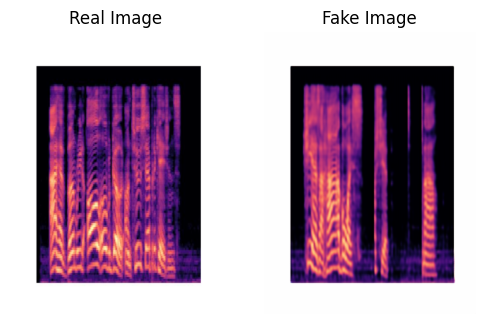

Epoch 10: Step 1400: Generator (U-Net) loss: 1.1074220344424248, Discriminator loss: 0.2506317838281394


<Figure size 600x600 with 0 Axes>

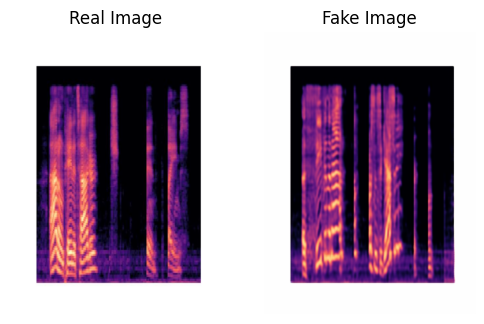

Epoch 11: Step 1600: Generator (U-Net) loss: 1.0499999749660494, Discriminator loss: 0.2503238572180271


<Figure size 600x600 with 0 Axes>

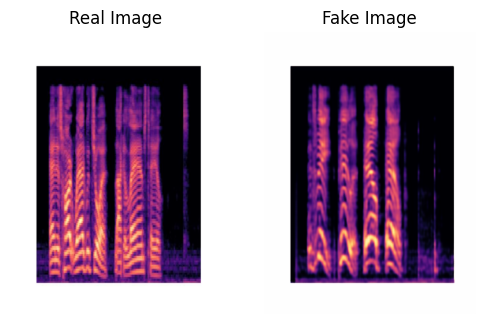

Epoch 12: Step 1800: Generator (U-Net) loss: 1.0496862620115284, Discriminator loss: 0.2500039166212083


<Figure size 600x600 with 0 Axes>

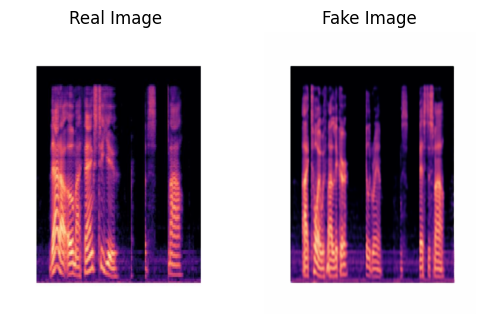

Epoch 14: Step 2000: Generator (U-Net) loss: 1.0102610254287716, Discriminator loss: 0.2495863963663578


<Figure size 600x600 with 0 Axes>

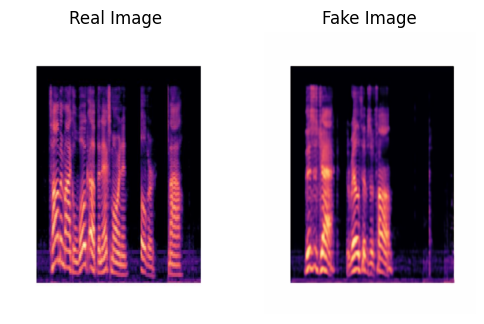

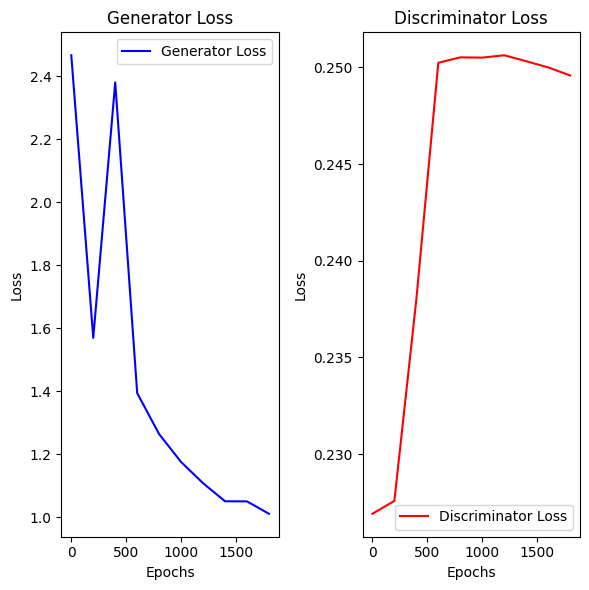

In [18]:
Happy_Gan = CycleGan(3,3,'Happy',load_model=False)
loss_gen, loss_disc = train(Happy_Gan)
Loss_plot(loss_gen, loss_disc,'Happy')

0
Epoch 0: Step 0: Generator (U-Net) loss: 0.09624241828918458, Discriminator loss: 0.0023753219842910767


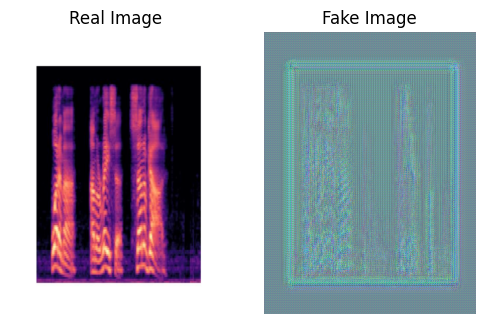

Epoch 1: Step 200: Generator (U-Net) loss: 2.059029020071031, Discriminator loss: 0.2493886455893517


<Figure size 600x600 with 0 Axes>

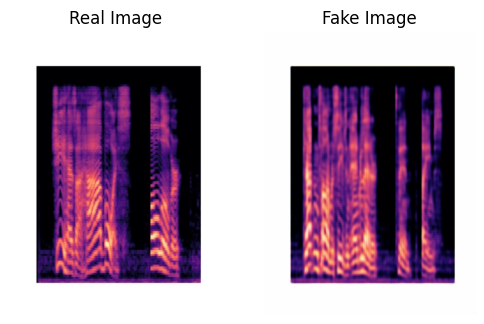

Epoch 2: Step 400: Generator (U-Net) loss: 1.262901743650438, Discriminator loss: 0.24934833623468877


<Figure size 600x600 with 0 Axes>

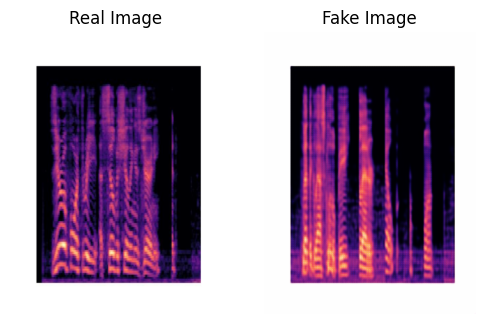

Epoch 4: Step 600: Generator (U-Net) loss: 1.104863032102585, Discriminator loss: 0.24860992453992364


<Figure size 600x600 with 0 Axes>

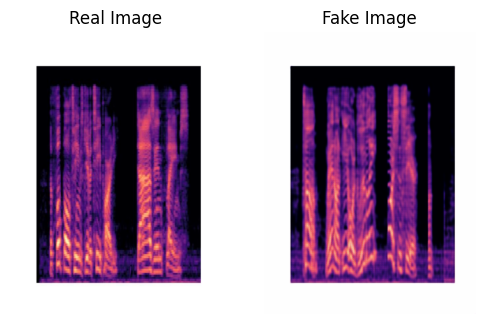

Epoch 5: Step 800: Generator (U-Net) loss: 1.0391006180644027, Discriminator loss: 0.2489620937407015


<Figure size 600x600 with 0 Axes>

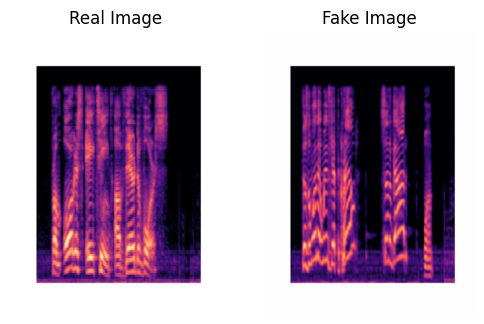

Epoch 7: Step 1000: Generator (U-Net) loss: 0.981904839575291, Discriminator loss: 0.24936960391700272


<Figure size 600x600 with 0 Axes>

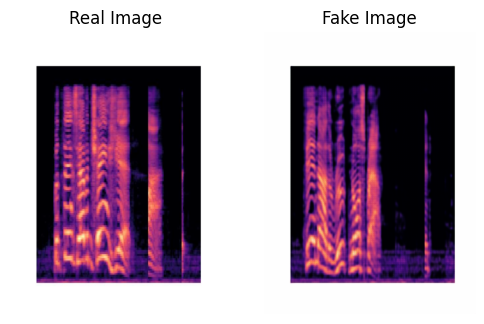

Epoch 8: Step 1200: Generator (U-Net) loss: 0.9539967668056484, Discriminator loss: 0.24907713115215316


<Figure size 600x600 with 0 Axes>

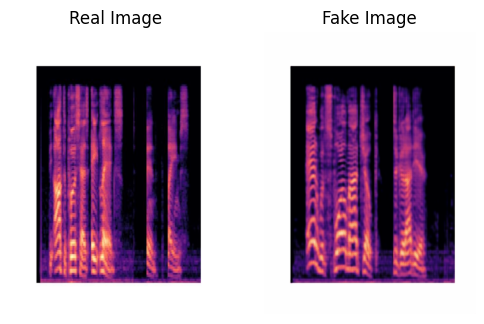

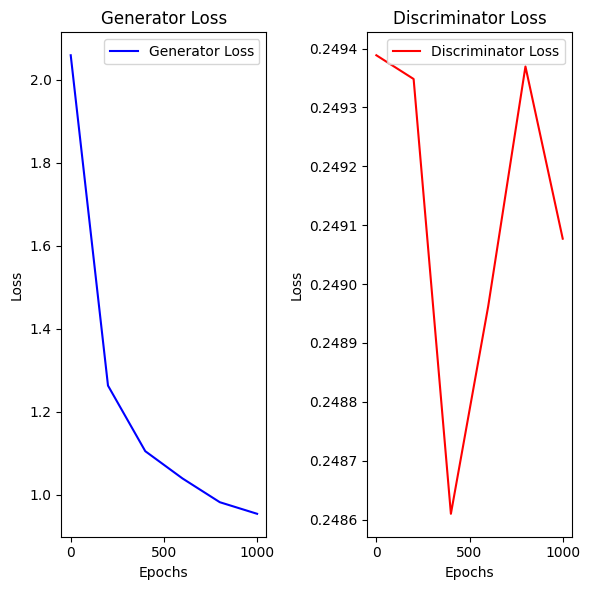

In [21]:
Angry_Gan = CycleGan(3,3,'Angry',load_model=False)
loss_gen, loss_disc = train(Angry_Gan)
Loss_plot(loss_gen, loss_disc,'Angry')

2
Epoch 0: Step 0: Generator (U-Net) loss: 0.09100288391113281, Discriminator loss: 0.002716885507106781


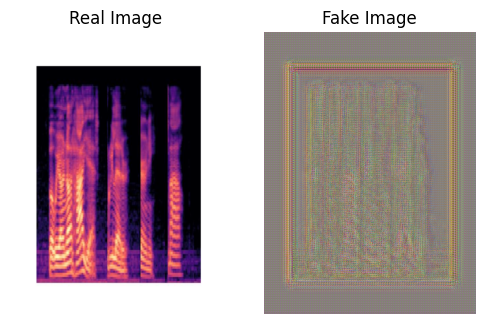

Epoch 1: Step 200: Generator (U-Net) loss: 2.0539734750986094, Discriminator loss: 0.2552291856706143


<Figure size 600x600 with 0 Axes>

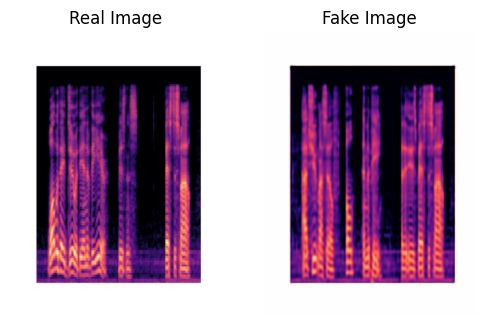

Epoch 2: Step 400: Generator (U-Net) loss: 1.2202658608555792, Discriminator loss: 0.25126228496432307


<Figure size 600x600 with 0 Axes>

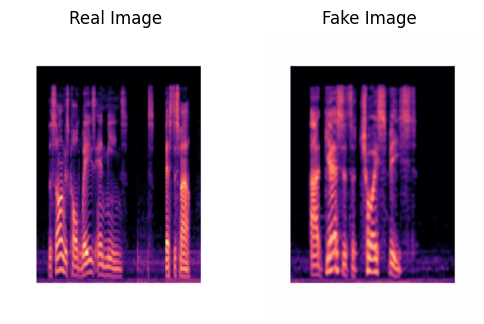

Epoch 4: Step 600: Generator (U-Net) loss: 1.1158493545651436, Discriminator loss: 0.2502552968263627


<Figure size 600x600 with 0 Axes>

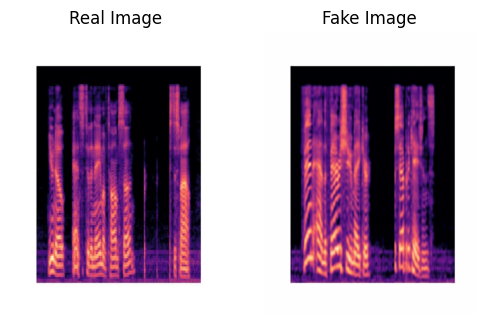

Epoch 5: Step 800: Generator (U-Net) loss: 1.0474876040220265, Discriminator loss: 0.2502022953331472


<Figure size 600x600 with 0 Axes>

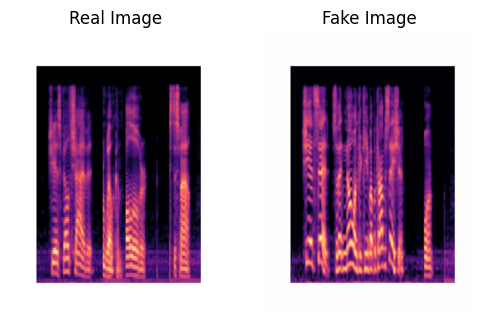

Epoch 7: Step 1000: Generator (U-Net) loss: 1.0061289393901829, Discriminator loss: 0.25004007294774044


<Figure size 600x600 with 0 Axes>

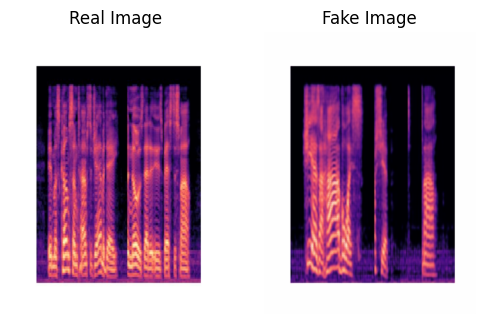

Epoch 8: Step 1200: Generator (U-Net) loss: 0.9691232642531389, Discriminator loss: 0.25018422208726415


<Figure size 600x600 with 0 Axes>

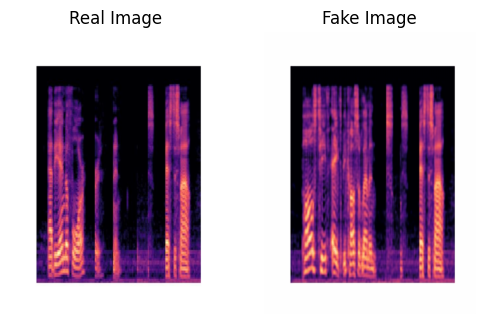

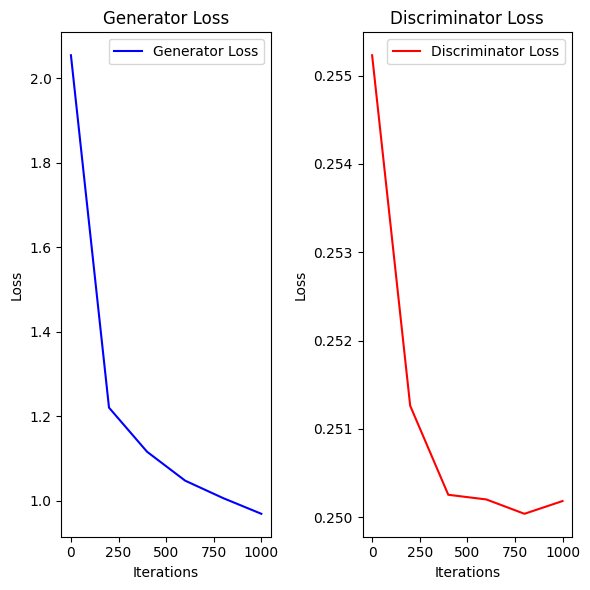

In [23]:
Neutral_Gan = CycleGan(3,3,'Neutral',load_model=False)
loss_gen, loss_disc = train(Neutral_Gan)
Loss_plot(loss_gen, loss_disc,'Neutral')

3
Epoch 0: Step 0: Generator (U-Net) loss: 0.00834301233291626, Discriminator loss: 0.0008750137686729431


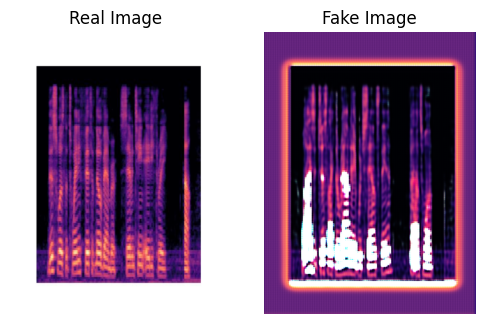

Epoch 1: Step 200: Generator (U-Net) loss: 1.6788929367065426, Discriminator loss: 0.20721404850482936


<Figure size 600x600 with 0 Axes>

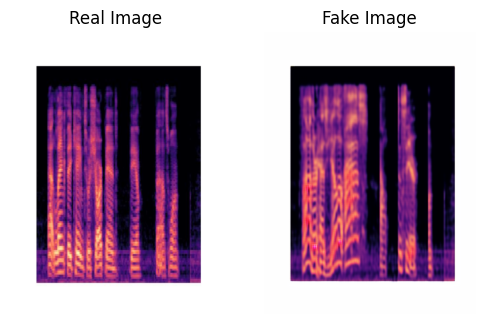

Epoch 2: Step 400: Generator (U-Net) loss: 1.1186592611670503, Discriminator loss: 0.25159533321857436


<Figure size 600x600 with 0 Axes>

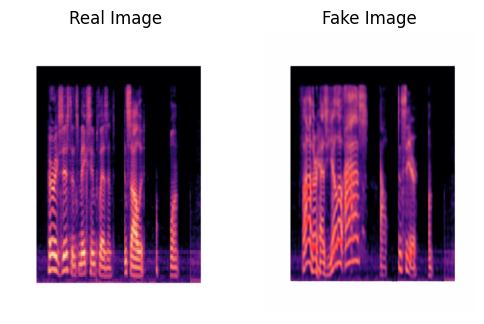

Epoch 4: Step 600: Generator (U-Net) loss: 1.0457611292600633, Discriminator loss: 0.25054510124027735


<Figure size 600x600 with 0 Axes>

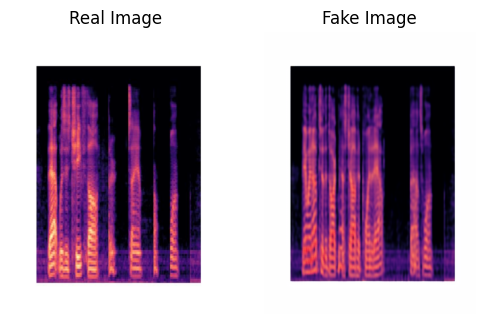

Epoch 5: Step 800: Generator (U-Net) loss: 1.005133330225945, Discriminator loss: 0.25005175150930886


<Figure size 600x600 with 0 Axes>

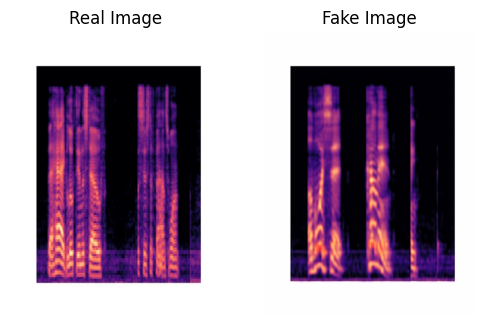

Epoch 7: Step 1000: Generator (U-Net) loss: 0.9771593144536018, Discriminator loss: 0.25014741785824285


<Figure size 600x600 with 0 Axes>

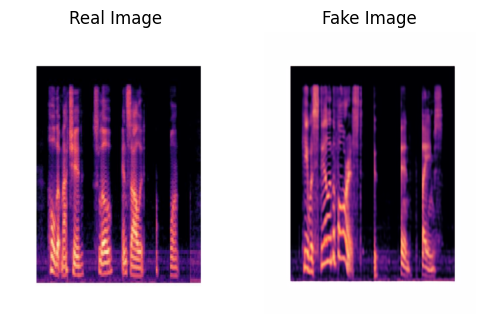

Epoch 8: Step 1200: Generator (U-Net) loss: 0.9526629197597504, Discriminator loss: 0.2499860108643771


<Figure size 600x600 with 0 Axes>

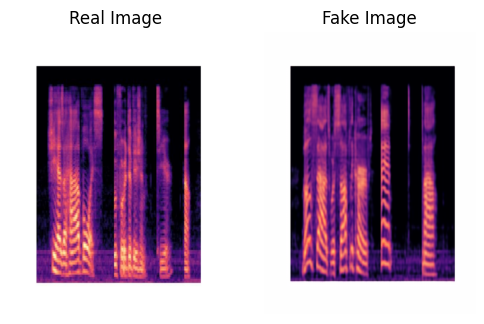

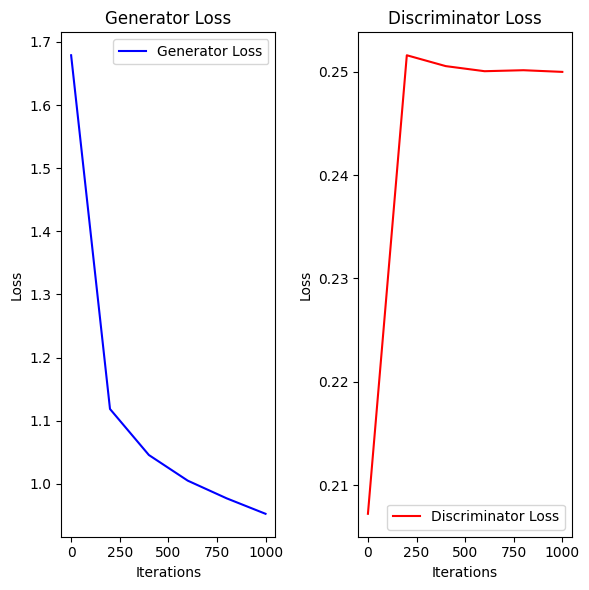

In [11]:
Sad_Gan = CycleGan(3,3,'Sad',load_model=True)
loss_gen, loss_disc = train(Sad_Gan)
Loss_plot(loss_gen, loss_disc,'Sad')

4
Epoch 0: Step 0: Generator (U-Net) loss: 0.007855867147445678, Discriminator loss: 0.0010924173891544342


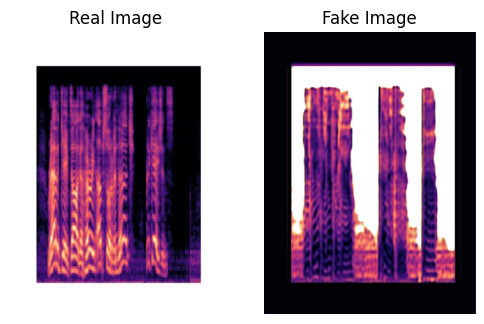

Epoch 1: Step 200: Generator (U-Net) loss: 1.559574225544929, Discriminator loss: 0.21966045424342162


<Figure size 600x600 with 0 Axes>

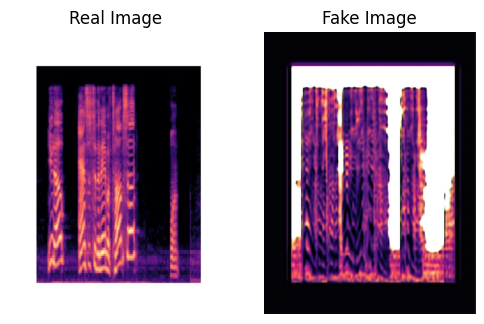

Epoch 2: Step 400: Generator (U-Net) loss: 1.5375916492939015, Discriminator loss: 0.22003287650644776


<Figure size 600x600 with 0 Axes>

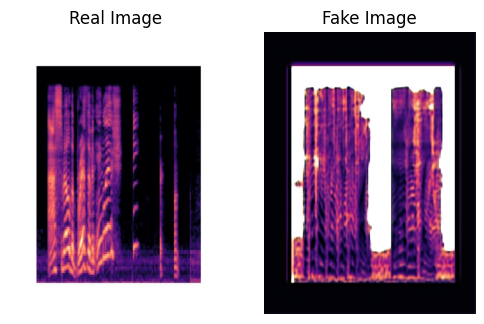

Epoch 4: Step 600: Generator (U-Net) loss: 1.4890620779991135, Discriminator loss: 0.21979003332555302


<Figure size 600x600 with 0 Axes>

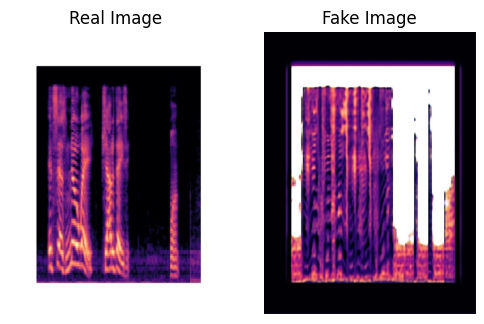

Epoch 5: Step 800: Generator (U-Net) loss: 1.4818420767784122, Discriminator loss: 0.21904600128531468


<Figure size 600x600 with 0 Axes>

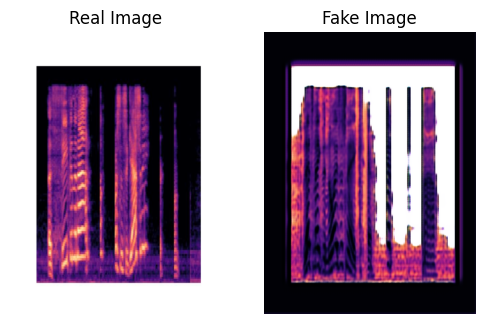

Epoch 7: Step 1000: Generator (U-Net) loss: 1.4891862255334858, Discriminator loss: 0.21909550897777072


<Figure size 600x600 with 0 Axes>

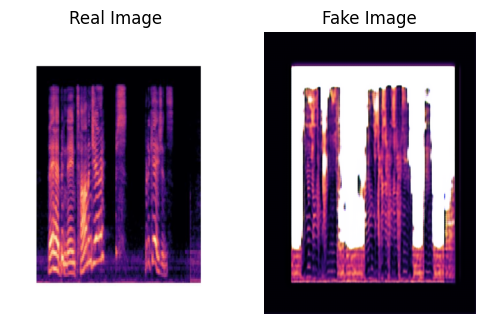

Epoch 8: Step 1200: Generator (U-Net) loss: 1.4662165957689282, Discriminator loss: 0.2188349569588899


<Figure size 600x600 with 0 Axes>

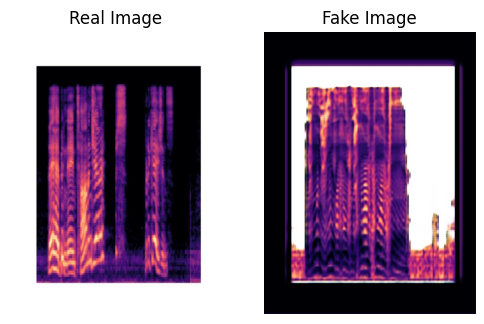

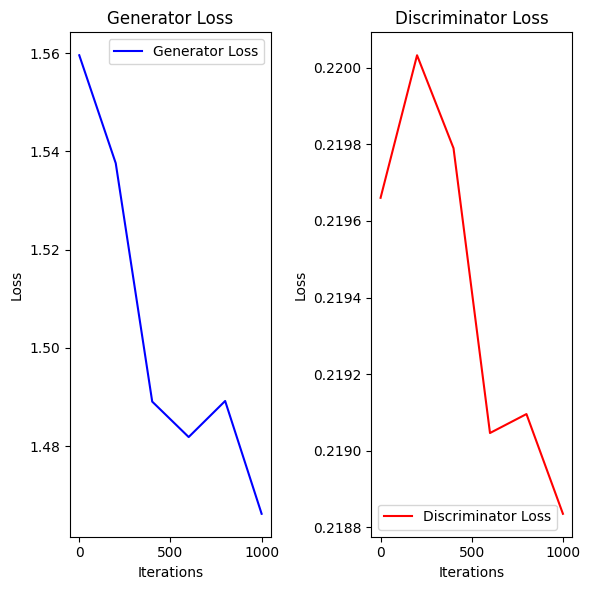

In [13]:
Surprise_Gan = CycleGan(3,3,'Surprise',load_model=True)
loss_gen, loss_disc = train(Surprise_Gan)
Loss_plot(loss_gen, loss_disc,'Surprise')